In [1]:
%load_ext autoreload
%autoreload 2
#---------------------------Imports-------------------------------------------
import numpy as np
import pandas as pd
import os
import glob
import importlib
import matplotlib.pyplot as plt

import sys

# Add Help_functions directory to the system path - Kommer bli en del sånt nu framöver
sys.path.append(os.path.join(os.getcwd(), 'Help_functions'))


import sympy as sp

from Data_Cleaning_test import*


#----------------------------load_data delete ()-----------------------------------
folder_path = 'C:\\Users\\Master_Student\\ml\\Data\\data_oct_2023\\features\\'
df = import_and_combine_data(folder_path)
# Delete all parentheses in column names, this for PySRRegressor to work
df.columns = df.columns.str.replace(r'\(.*?\)', '', regex=True).str.strip()
#print(df.columns)

In [2]:
def extract_filled_segments(filled_data):
   """
   Extract just the filled segments from the filled_data structure.
   
   Parameters:
   - filled_data: Dictionary containing the full output structure from fill_gaps()
   
   Returns:
   - Dictionary containing just the filled DataFrames, maintaining the round/device structure
   """
   filled_segments = {}
   for round_number, devices in filled_data.items():
       filled_segments[round_number] = {}
       for device, device_data in devices.items():
           if device_data is not None:
               filled_segments[round_number][device] = device_data[0]  # Get just the filled_segment
           else:
               filled_segments[round_number][device] = None
   
   return filled_segments

In [3]:
#---------------------------Fix Missing data-------------------------------------------
def fix_missing_data(group):
    # Interpolate
    group = group.interpolate(method='linear')
    # Forward fill
    group = group.ffill()
    # Backward fill
    group = group.bfill()
    return group

# Apply all operations in a single pass
grouped = df.groupby(['round', 'device'], group_keys=False)
df = grouped.apply(fix_missing_data)

df['swing_temperature'] = df['max_temperature'] - df['min_temperature'] 

# Reorder the columns to place 'swing_temperature' at index 8
columns = df.columns.tolist()  # Get the list of column names
columns.remove('swing_temperature')  # Remove 'swing_temperature' from its current position
columns.insert(8, 'swing_temperature')  # Insert 'swing_temperature' at index 8
df = df[columns]  # Reorder the DataFrame columns

#-----------------------------Abbrevations for plotting---------------------------------------------

temperature_columns = [
    'min_temperature', 
    'max_temperature', 
    'min_block_temperature_1', 
    'max_block_temperature_1', 
    'min_block_temperature_2', 
    'max_block_temperature_2', 
    'avg_max_block_temperature', 
    'min_water_inlet_temperature',
    'max_water_inlet_temperature', 
    'min_water_outlet_temperature', 
    'max_water_outlet_temperature', 
]
# Create the abbreviation dictionary for renaming the columns
abbreviations = {
    'cycle': 'Cyc',
    'consumed_life': 'CL',
    'end_voltage': 'V_end',
    'end_resistance': 'R_end',
    'end_resistance_residual': 'R_res',
    'end_resistance_residual_cleaned': 'R_res_cl',
    'min_temperature': 'T_min',
    'max_temperature': 'T_max',
    'min_block_temperature_1': 'T_B1_min',
    'max_block_temperature_1': 'T_B1_max',
    'min_block_temperature_2': 'T_B2_min',
    'max_block_temperature_2': 'T_B2_max',
    'avg_max_block_temperature': 'T_B_avg_max',
    'min_water_inlet_temperature': 'T_WI_min',
    'max_water_inlet_temperature': 'T_WI_max',
    'min_water_outlet_temperature': 'T_WO_min',
    'max_water_outlet_temperature': 'T_WO_max',
    'swing_temperature': 'T_Sw'
} 

columns_to_clean = ['end_voltage', 'end_resistance',
       'end_resistance_residual', 'end_resistance_residual_cleaned',
       'min_temperature', 'max_temperature', 'min_block_temperature_1',
       'max_block_temperature_1', 'min_block_temperature_2',
       'max_block_temperature_2', 'avg_max_block_temperature',
       'min_water_inlet_temperature', 'max_water_inlet_temperature',
       'min_water_outlet_temperature', 'max_water_outlet_temperature', 'swing_temperature'] # tar bort cycle!

# Function to replace column names with abbreviations
def get_abbreviation(column_name):
    return abbreviations.get(column_name, column_name)  # Use the abbreviation if it exists, otherwise use the original name



#---------------------------------------Get rid of unphyiscal temperature drops in the data---------------------------------------------------------------

#-----------------------------------------------Filtrera datan-----------------------------------------------------

devices = list(range(1,11)) # ska vara 11 här !
rounds = [8, 9]

segmented_data = make_segments(
    df=df,
    devices=devices,
    rounds=rounds,
    cut_at_CL_one=True,       # Remove rows with consumed_life > 1      # Minimum segment size to keep
    cycle_threshold=2000       # Remove rows with cycle < 500
)


filtered_data = exclude_transition_cycles(
    segmented_data=segmented_data, 
    transition_margin=100,  # Standard transition margin 75 förr
    filter_columns=columns_to_clean,
    verbose=True
)

merged_data, aligned_data = merge_segments(
    segmented_data=filtered_data,
    devices=devices,
    rounds=[8, 9],
    columns_to_merge= columns_to_clean,
    mean_interval_proportion=0.1, # 0.1
    min_interval=10,
    max_interval=500,
    transition_margin=10
)

#print(adjusted_segmented_data)
filled_merged_data, gap_statistics = fill_gaps(
   merged_data=merged_data,
   columns_to_fill=columns_to_clean,
    window_size= 1000
)

window_size = 250  
m_average_data = calculate_moving_averages(filled_merged_data, window_size)

filled_segments = extract_filled_segments(filled_merged_data)

round_dict = devices_combined_into_one_df(m_average_data, [8,9]) #--------------- bra
round_dict2 = devices_combined_into_one_df(filled_segments, [8,9])

df_new = combine_all_rounds(round_dict)
df_no_mavg = combine_all_rounds(round_dict2)


C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\767453940.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(fix_missing_data)


segment_devices_data:
Total rows removed: 67385.00 out of 1055440.00 (6.38%)
Rows removed due to consumed_life > 1: 27405.00
Rows removed due to cycle < 2000.00: 39980.00
----------------------------------------------------------------------------
exclude_transition_cycles:
Total rows marked as NaN: 24329.00 out of 988055.00 (2.46%)
Total individual NaN values marked: 389264.00
----------------------------------------------------------------------------
fill_gaps:
Total NaN values filled: 389,264 out of 15,808,880 values (2.46%)
Gap Statistics: Max=343.00, Min=102.00, Mean=211.56, Std=40.67, Total Gaps=1840.00
----------------------------------------------------------------------------
calculate_moving_averages
Total rows removed: 4980 out of 988055 (0.50%)
Expected rows removed due to window size (250): 4980.00
--------------------------------------------------------------------------------------------


In [4]:
# extra df
df_8_and_9 = df[df['round'].isin([8, 9])].copy()
df_feasible_r = df_8_and_9[(df_8_and_9['cycle'] >= 2000) & (df_8_and_9['consumed_life'] <= 1)]

In [5]:
def find_consumed_life_1(df):
    """
    Returns the cycle at which consumed life (consumed_life) equals 1 for each device in all rounds.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame should have 'consumed_life', 'device', and 'round', 
                           and the 'cycle' column should represent the progression of cycles.
    
    Returns:
    pandas.DataFrame: A DataFrame with 'round', 'device', and the corresponding 'cycle' where consumed_life = 1.
    """
    # Filter for rows where consumed life (consumed_life) is equal to 1
    life_end_df = df[df['consumed_life'] == 1]
    
    # Group by 'round' and 'device', then find the first cycle where consumed_life = 1
    result = life_end_df.groupby(['round', 'device']).apply(lambda x: x['cycle'].min()).reset_index()
    
    # Rename the columns for clarity
    result.columns = ['round', 'device', 'Cyc_at_CL_1']
    
    return result




In [8]:
def calculate_round_mean_correlation_matrix(df, specific_rounds=None):
    """
    Calculate correlation matrices per round and return their mean.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - specific_rounds: list of rounds to include (default: None, includes all rounds)
    
    Returns:
    - mean_correlation_matrix: pandas DataFrame with the averaged correlation matrix
    """
    # Filter for specific rounds if provided
    if specific_rounds is not None:
        df = df[df['round'].isin(specific_rounds)]
    
    # Get all rounds
    rounds = sorted(df['round'].unique())
    
    # List to store correlation matrices
    correlation_matrices = []
    
    # Calculate correlation matrix for each round
    for round_num in rounds:
        # Get data for this round
        round_data = df[df['round'] == round_num]
        
        # Drop non-numeric columns
        numeric_df = round_data.select_dtypes(include=[np.number])
        
        # Drop grouping columns
        columns_to_drop = ['round', 'device']
        for col in columns_to_drop:
            if col in numeric_df.columns:
                numeric_df = numeric_df.drop(col, axis=1)
        
        # Calculate correlation matrix for this round
        round_corr = numeric_df.corr()
        
        # Store the correlation matrix
        correlation_matrices.append(round_corr)
    
    # Calculate mean correlation matrix
    mean_correlation_matrix = pd.concat(correlation_matrices).groupby(level=0).mean()
    
    return mean_correlation_matrix

# Example usage
round_mean_corr_df_new = calculate_round_mean_correlation_matrix(df_new)
round_mean_corr_df = calculate_round_mean_correlation_matrix(df)

# For specific rounds
round_mean_corr_df_8_9 = calculate_round_mean_correlation_matrix(df_new, specific_rounds=[8, 9])


In [9]:
def calculate_mean_correlation_matrix(df, group_columns=['round', 'device'], specific_rounds=None):
   """
   Calculate mean correlation matrix across groups in the data.
   
   Parameters:
   - df: pandas DataFrame containing the data
   - group_columns: list of column names to group by (default: ['round', 'device'])
   - specific_rounds: list of rounds to include (default: None, includes all rounds)
   
   Returns:
   - mean_correlation_matrix: pandas DataFrame with the mean correlation matrix
   """
   # Filter for specific rounds if provided
   if specific_rounds is not None:
       df = df[df['round'].isin(specific_rounds)]
   
   # Group the data
   grouped = df.groupby(group_columns)
   
   # Initialize list to hold correlation matrices
   correlation_matrices = []
   
   # Calculate correlation matrix for each group
   for name, group in grouped:
       # Drop grouping columns to focus on numerical data
       group_numerical = group.drop(group_columns, axis=1)
       
       # Calculate correlation matrix for this group
       correlation_matrix = group_numerical.corr()
       
       # Store the correlation matrix
       correlation_matrices.append(correlation_matrix)
   
   # Calculate mean correlation matrix
   mean_correlation_matrix = pd.concat(correlation_matrices).groupby(level=0).mean()
   
   return mean_correlation_matrix


# Example usage: Per device
mean_corr_df = calculate_mean_correlation_matrix(df)
mean_corr_df_feasible_r = calculate_mean_correlation_matrix(df_feasible_r)
mean_corr_df_new = calculate_mean_correlation_matrix(df_new)  # All rounds
mean_corr_df_no_mavg = calculate_mean_correlation_matrix(df_no_mavg)  # All rounds
mean_corr_df_8_and_9 = calculate_mean_correlation_matrix(df_8_and_9)  # Only rounds 8 and 9



In [10]:
def rename_correlation_matrix(corr_matrix):
    """
    Rename and reorder correlation matrix columns and indices.
    """
    # Exact matching of column names from your correlation matrix
    abbreviations = {
        'cycle': 'Cyc',
        'consumed_life': 'CL',
        'end_voltage': 'V_end',
        'end_resistance': 'R_end',
        'end_resistance_residual': 'R_res',
        'end_resistance_residual_cleaned': 'R_res_cl',
        'min_temperature': 'T_min',
        'max_temperature': 'T_max',
        'min_block_temperature_1': 'T_B1_min',
        'max_block_temperature_1': 'T_B1_max',
        'min_block_temperature_2': 'T_B2_min',
        'max_block_temperature_2': 'T_B2_max',
        'avg_max_block_temperature': 'T_B_avg_max',
        'min_water_inlet_temperature': 'T_WI_min',
        'max_water_inlet_temperature': 'T_WI_max',
        'min_water_outlet_temperature': 'T_WO_min',
        'max_water_outlet_temperature': 'T_WO_max',
        'swing_temperature': 'T_Sw'
    }

    # Debug print
    print("Original columns:", corr_matrix.columns.tolist())
    print("Original index:", corr_matrix.index.tolist())

    # Rename columns and index
    processed = corr_matrix.copy()  # Make a copy to avoid modifying original
    processed.columns = [abbreviations.get(col, col) for col in processed.columns]
    processed.index = [abbreviations.get(idx, idx) for idx in processed.index]

    # Define desired order
    desired_order = ['Cyc', 'CL', 'V_end', 'R_end', 'R_res', 'R_res_cl',
                    'T_min', 'T_max', 'T_B1_min', 'T_B1_max', 'T_B2_min', 'T_B2_max',
                    'T_B_avg_max', 'T_WI_min', 'T_WI_max', 'T_WO_min', 'T_WO_max', 'T_Sw']

    # Get available columns in desired order
    available_order = [col for col in desired_order if col in processed.columns]
    
    # Debug print
    print("Available columns after renaming:", processed.columns.tolist())
    print("Columns to be used for reordering:", available_order)

    # Reorder if there are matching columns
    if available_order:
        processed = processed.loc[available_order, available_order]

    return processed

# Try the function and print results at each step
print("Original correlation matrix:")
print(mean_corr_df)
print("\nRenamed correlation matrix:")
renamed_matrix = rename_correlation_matrix(mean_corr_df)
print(renamed_matrix)

# Usage:
mean_corr_df= rename_correlation_matrix(mean_corr_df)
mean_corr_df_feasible_r = rename_correlation_matrix(mean_corr_df_feasible_r)
mean_corr_df_no_mavg = rename_correlation_matrix(mean_corr_df_no_mavg)
mean_corr_df_new = rename_correlation_matrix(mean_corr_df_new)
mean_corr_df_8_and_9 = rename_correlation_matrix(mean_corr_df_8_and_9)

# test
round_mean_corr_df_new = rename_correlation_matrix(round_mean_corr_df_new)
round_mean_corr_df = rename_correlation_matrix(round_mean_corr_df)



Original correlation matrix:
                                    cycle  consumed_life  end_voltage  \
avg_max_block_temperature       -0.556492      -0.556492     0.080973   
consumed_life                    1.000000       1.000000     0.271388   
cycle                            1.000000       1.000000     0.271388   
end_resistance                   0.271388       0.271388     1.000000   
end_resistance_residual          0.555284       0.555284     0.826628   
end_resistance_residual_cleaned  0.555456       0.555456     0.826989   
end_voltage                      0.271388       0.271388     1.000000   
max_block_temperature_1         -0.553066      -0.553066     0.082738   
max_block_temperature_2         -0.549463      -0.549463     0.082665   
max_temperature                 -0.258912      -0.258912     0.643182   
max_water_inlet_temperature     -0.211848      -0.211848     0.108152   
max_water_outlet_temperature    -0.305983      -0.305983     0.104841   
min_block_temperature_

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\433340222.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


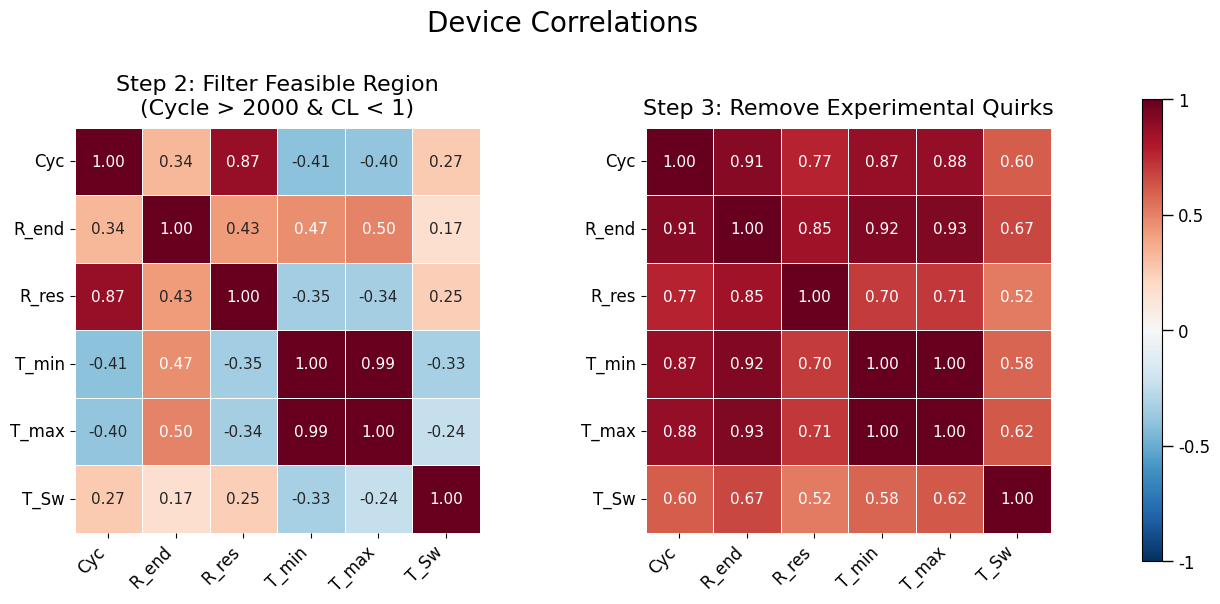

In [12]:
def plot_correlation_comparison(corr2, corr3, properties, figsize=(15, 6)):
    """
    Create a publication-ready comparison showing two specific cleaning steps through correlation matrices,
    using a 3-grid layout with the colorbar in the last position.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create a 1x3 grid layout with the last column narrower for the colorbar
    fig, axes = plt.subplots(1, 3, figsize=figsize, gridspec_kw={
        'width_ratios': [1, 1, 0.05],  # Make the last column narrower for colorbar
        'wspace': 0.6,  # Increased spacing between heatmaps
        'hspace': 0
    })
    
    matrices = [corr2, corr3]
    titles = [
        'Step 2: Filter Feasible Region\n(Cycle > 2000 & CL < 1)',
        'Step 3: Remove Experimental Quirks'
    ]
    
    # Common base parameters
    base_params = {
        'annot': True,
        'fmt': '.2f',
        'square': True,
        'linewidths': 0.5,
        'annot_kws': {'size': 11},
        'cmap': 'RdBu_r',
        'vmin': -1.0,
        'vmax': 1.0,
        'cbar': False  # Don't create individual colorbars
    }
    
    # Plot heatmaps in first two axes
    for idx, (ax, matrix, title) in enumerate(zip(axes[:2], matrices, titles)):
        # Ensure consistent subset for both matrices
        matrix_subset = matrix.loc[properties, properties]
        
        # Create heatmap
        sns.heatmap(matrix_subset, ax=ax, **base_params)
        
        # Customize axes
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
        ax.set_title(title, fontsize=16, pad=10)
        
        # Force aspect ratio to be equal
        ax.set_aspect('equal')
    
    # Create a single colorbar in the third axis
    norm = plt.Normalize(vmin=-1, vmax=1)
    from matplotlib.colorbar import ColorbarBase
    cbar = ColorbarBase(axes[2], cmap=plt.get_cmap('RdBu_r'), norm=norm)
    cbar.set_ticks([-1, -0.5, 0, 0.5, 1])  # Set specific tick locations
    cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1'])  # Set tick labels
    cbar.ax.tick_params(labelsize=12,    # Increase label size
                   length=8,         # Increase tick length
                   width=1)          # Increase tick width
    
    
    # Move the colorbar closer to the second heatmap
    pos = axes[2].get_position()
    axes[2].set_position([pos.x0 - 0.05, pos.y0, pos.width, pos.height])
    
    # Calculate the center point between the two heatmaps for the title
    left_pos = axes[0].get_position()
    right_pos = axes[1].get_position()
    center_x = (left_pos.x0 + right_pos.x1) / 2
    
    # Add main title centered over the two heatmaps
    fig.suptitle('Device Correlations', x=center_x, y=1.03, fontsize=20)
    
    # Hide the empty axes frame for the colorbar
    axes[2].set_frame_on(True)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, axes

# Usage:
properties = ['Cyc', 'R_end', 'R_res', 'T_min', 'T_max', 'T_Sw']
fig, axes = plot_correlation_comparison(
    mean_corr_df_feasible_r,
    mean_corr_df_no_mavg,
    properties
)
fig.savefig('Cleaning_Steps_Device_Correlations_2Grid.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\2493922707.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


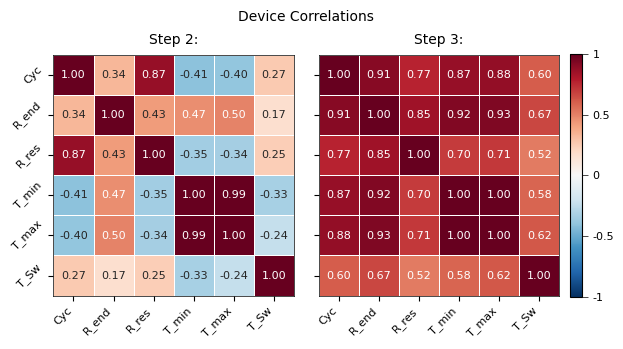

In [14]:
import seaborn as sns
def plot_correlation_comparison(corr2, corr3, properties, figsize=None):
    """
    Create a publication-ready comparison of correlation matrices optimized for A4 text width.
    """
    # A4 text width (160mm ≈ 6.3 inches)
    TEXT_WIDTH_INCHES = 7

    if figsize is None:
        width = TEXT_WIDTH_INCHES
        height = width * 0.45  # Maintain same proportions as plot_temperature_comparison
        figsize = (width, height)

    # Optimized font sizes for A4 width
    MAIN_TITLE_SIZE = 10
    SUBTITLE_SIZE = 10
    TICK_LABEL_SIZE = 8
    ANNOTATION_SIZE = 8

    fig, axes = plt.subplots(1, 3, figsize=figsize, gridspec_kw={
        'width_ratios': [1, 1, 0.05],  # Two heatmaps, one colorbar
        'wspace': 0.15,  # Reduced spacing between heatmaps
        'hspace': 0
    })

    # Base parameters for the heatmaps
    base_params = {
        'annot': True,
        'fmt': '.2f',
        'square': True,
        'linewidths': 0.5,
        'annot_kws': {'size': ANNOTATION_SIZE},
        'cmap': 'RdBu_r',
        'vmin': -1.0,
        'vmax': 1.0,
        'cbar': False
    }

    # Subset matrices and plot heatmaps
    sns.heatmap(corr2.loc[properties, properties], ax=axes[0], **base_params)
    sns.heatmap(corr3.loc[properties, properties], ax=axes[1], **base_params)

    # Customize axes
    titles = [
        'Step 2:',
        'Step 3:'
    ]

    for idx, (ax, title) in enumerate(zip(axes[:2], titles)):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=TICK_LABEL_SIZE)

        # Only show y-labels for the first (leftmost) plot
        if idx == 0:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right', fontsize=TICK_LABEL_SIZE)
        else:
            ax.set_yticklabels([])  # Hide y-labels for other plots

        ax.set_title(title, fontsize=SUBTITLE_SIZE, pad=8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_aspect('equal')

        for spine in ax.spines.values():
            spine.set_linewidth(0.5)
            spine.set_visible(True)

    # Add a shared colorbar in the third axis
    from matplotlib.colorbar import ColorbarBase
    norm = plt.Normalize(vmin=-1, vmax=1)
    cbar = ColorbarBase(axes[2], cmap=plt.get_cmap('RdBu_r'), norm=norm)
    cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
    cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1'])
    cbar.ax.tick_params(labelsize=TICK_LABEL_SIZE, length=4, width=0.5)

    # Improved colorbar positioning
    pos = axes[2].get_position()
    axes[2].set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])

    # Title positioning
    left_pos = axes[0].get_position()
    right_pos = axes[1].get_position()
    center_x = (left_pos.x0 + right_pos.x1) / 2

    fig.suptitle('Device Correlations', x=center_x, y=1.02, fontsize=MAIN_TITLE_SIZE)

    plt.tight_layout()
    return fig, axes


# Usage:
properties = ['Cyc', 'R_end', 'R_res', 'T_min', 'T_max', 'T_Sw']
fig, axes = plot_correlation_comparison(
    mean_corr_df_feasible_r,
    mean_corr_df_no_mavg,
    properties
)
fig.savefig('Device_Correlations.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# Beräknar Korrelationen för round properties dvs endast för den runda som lever längst

def calculate_mean_correlation_matrix(df, abbreviations):
    """
    Calculate the mean correlation matrix for selected rows in the DataFrame based on matching rounds and devices.
    
    Parameters:
    - df (pd.DataFrame): The main DataFrame containing the data.
    - abbreviations (dict): Dictionary for renaming columns and index for the correlation matrix.
    
    Returns:
    - mean_correlation_matrix (pd.DataFrame): The mean correlation matrix.
    """
    # Find highest cycle per round using find_consumed_life_1
    data = find_consumed_life_1(df)
    
    # Get only the rounds that exist in the original dataframe
    available_rounds = df['round'].unique()
    data = data[data['round'].isin(available_rounds)]
    
    highest_cyc_per_round = data.loc[data.groupby('round')['Cyc_at_CL_1'].idxmax()]
    highest_cyc_per_round.reset_index(drop=True, inplace=True)
    
    print("Available rounds in df:", sorted(available_rounds))
    print("\nHighest cycles per round:")
    print(highest_cyc_per_round)
    
    # Initialize variables for correlation calculation
    correlation_sum = None
    total_matrices = 0
    
    # Iterate over each row in highest_cyc_per_round
    for index, row in highest_cyc_per_round.iterrows():
        round_value = row['round']
        device_value = row['device']
        
        print(f'\nProcessing round: {round_value}, device: {device_value}')
        
        # Find matching rows
        matching_rows = df[(df['round'] == round_value) & (df['device'] == device_value)]
        print(f'Found {len(matching_rows)} matching rows')
        
        # Compute correlation matrix if enough data
        if len(matching_rows) > 1:
            corr_matrix = matching_rows.corr()
            
            if correlation_sum is None:
                correlation_sum = corr_matrix
            else:
                correlation_sum += corr_matrix
                
            total_matrices += 1
            print(f'Added correlation matrix. Total matrices: {total_matrices}')
    
    # Compute mean correlation matrix
    mean_correlation_matrix = correlation_sum / total_matrices
    
    # Rename columns and index
    mean_correlation_matrix = mean_correlation_matrix.rename(columns=abbreviations)
    mean_correlation_matrix = mean_correlation_matrix.rename(index=abbreviations)
    
    return mean_correlation_matrix

# Example usage:
mean_corr_df_2 = calculate_mean_correlation_matrix(df, abbreviations)
mean_corr_df_new_2 = calculate_mean_correlation_matrix(df_new, abbreviations)
mean_corr_df_no_mavg_2 = calculate_mean_correlation_matrix(df_no_mavg, abbreviations)
mean_corr_df_8_and_9_2 = calculate_mean_correlation_matrix(df_8_and_9, abbreviations)
mean_corr_df_feasible_r_2= calculate_mean_correlation_matrix(df_feasible_r, abbreviations)

# Define properties for subsetting if needed
temp_properties = ['Cyc', 'T_B1_min', 'T_B1_max', 'T_B2_min', 'T_B2_max',
                 'T_B_avg_max', 'T_WI_min', 'T_WI_max', 'T_WO_min', 'T_WO_max']

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\2774071241.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = life_end_df.groupby(['round', 'device']).apply(lambda x: x['cycle'].min()).reset_index()


Available rounds in df: [np.int64(4), np.int64(5), np.int64(6), np.int64(8), np.int64(9)]

Highest cycles per round:
   round  device  Cyc_at_CL_1
0      4       3        26570
1      5       3       212134
2      6       3       185448
3      8       4       168756
4      9       9        96471

Processing round: 4, device: 3
Found 28521 matching rows
Added correlation matrix. Total matrices: 1

Processing round: 5, device: 3
Found 213399 matching rows
Added correlation matrix. Total matrices: 2

Processing round: 6, device: 3
Found 185492 matching rows
Added correlation matrix. Total matrices: 3

Processing round: 8, device: 4
Found 168920 matching rows
Added correlation matrix. Total matrices: 4

Processing round: 9, device: 9
Found 100567 matching rows
Added correlation matrix. Total matrices: 5
Available rounds in df: [np.int64(8), np.int64(9)]

Highest cycles per round:
   round  device  Cyc_at_CL_1
0      8       4       168756
1      9       9        96471

Processing round: 8,

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\2774071241.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = life_end_df.groupby(['round', 'device']).apply(lambda x: x['cycle'].min()).reset_index()


Added correlation matrix. Total matrices: 1

Processing round: 9, device: 9
Found 94217 matching rows
Added correlation matrix. Total matrices: 2
Available rounds in df: [np.int64(8), np.int64(9)]

Highest cycles per round:
   round  device  Cyc_at_CL_1
0      8       4       168756
1      9       9        96471

Processing round: 8, device: 4
Found 166757 matching rows


C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\2774071241.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = life_end_df.groupby(['round', 'device']).apply(lambda x: x['cycle'].min()).reset_index()


Added correlation matrix. Total matrices: 1

Processing round: 9, device: 9
Found 94466 matching rows
Added correlation matrix. Total matrices: 2
Available rounds in df: [np.int64(8), np.int64(9)]

Highest cycles per round:
   round  device  Cyc_at_CL_1
0      8       4       168756
1      9       9        96471

Processing round: 8, device: 4
Found 168920 matching rows


C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\2774071241.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = life_end_df.groupby(['round', 'device']).apply(lambda x: x['cycle'].min()).reset_index()


Added correlation matrix. Total matrices: 1

Processing round: 9, device: 9
Found 100567 matching rows
Added correlation matrix. Total matrices: 2
Available rounds in df: [np.int64(8), np.int64(9)]

Highest cycles per round:
   round  device  Cyc_at_CL_1
0      8       4       168756
1      9       9        96471

Processing round: 8, device: 4
Found 166757 matching rows


C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\2774071241.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = life_end_df.groupby(['round', 'device']).apply(lambda x: x['cycle'].min()).reset_index()


Added correlation matrix. Total matrices: 1

Processing round: 9, device: 9
Found 94466 matching rows
Added correlation matrix. Total matrices: 2


C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\3039251605.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


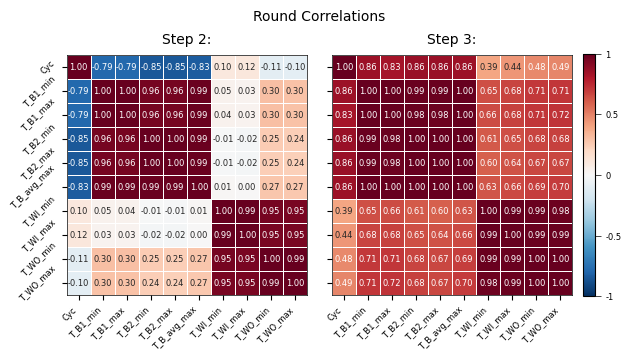

In [17]:
from matplotlib.colorbar import ColorbarBase

def plot_temperature_comparison(corr1, corr2, temp_properties, figsize=None):
    """
    Create a publication-ready comparison of temperature correlation matrices optimized for A4 text width.
    """
    # A4 text width (160mm ≈ 6.3 inches)
    TEXT_WIDTH_INCHES = 7

    if figsize is None:
        width = TEXT_WIDTH_INCHES
        height = width * 0.45  # Maintain same proportions as in plot_correlation_subset_comparison
        figsize = (width, height)

    # Optimized font sizes for A4 width
    MAIN_TITLE_SIZE = 10
    SUBTITLE_SIZE = 10
    TICK_LABEL_SIZE = 6
    ANNOTATION_SIZE = 6

    fig, axes = plt.subplots(1, 3, figsize=figsize, gridspec_kw={
        'width_ratios': [1, 1, 0.05],
        'wspace': 0.15,  # Reduced spacing between heatmaps
        'hspace': 0
    })

    base_params = {
        'annot': True,
        'fmt': '.2f',
        'square': True,
        'linewidths': 0.5,
        'annot_kws': {'size': ANNOTATION_SIZE},
        'cmap': 'RdBu_r',
        'vmin': -1.0,
        'vmax': 1.0,
        'cbar': False
    }

    # Plot heatmaps
    sns.heatmap(corr1.loc[temp_properties, temp_properties], ax=axes[0], **base_params)
    sns.heatmap(corr2.loc[temp_properties, temp_properties], ax=axes[1], **base_params)

    # Customize axes
    titles = [
        'Step 2:',
        'Step 3:'
    ]

    for idx, (ax, title) in enumerate(zip(axes[:2], titles)):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=TICK_LABEL_SIZE)

        # Only show y-labels for the first (leftmost) plot
        if idx == 0:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right', fontsize=TICK_LABEL_SIZE)
        else:
            ax.set_yticklabels([])  # Hide y-labels for other plots

        ax.set_title(title, fontsize=SUBTITLE_SIZE, pad=8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_aspect('equal')

        for spine in ax.spines.values():
            spine.set_linewidth(0.5)
            spine.set_visible(True)

    # Optimized colorbar
    norm = plt.Normalize(vmin=-1, vmax=1)
    cbar = ColorbarBase(axes[2], cmap=plt.get_cmap('RdBu_r'), norm=norm)
    cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
    cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1'])
    cbar.ax.tick_params(labelsize=TICK_LABEL_SIZE, length=4, width=0.5)

    # Improved colorbar positioning
    pos = axes[2].get_position()
    axes[2].set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])

    # Title positioning
    left_pos = axes[0].get_position()
    right_pos = axes[1].get_position()
    center_x = (left_pos.x0 + right_pos.x1) / 2

    fig.suptitle('Round Correlations', x=center_x, y=1.02, fontsize=MAIN_TITLE_SIZE)

    plt.tight_layout()
    return fig, axes


# Usage:
temp_properties = ['Cyc', 'T_B1_min', 'T_B1_max', 'T_B2_min', 'T_B2_max',
                   'T_B_avg_max', 'T_WI_min', 'T_WI_max', 'T_WO_min', 'T_WO_max']

fig, axes = plot_temperature_comparison(mean_corr_df_feasible_r_2, mean_corr_df_no_mavg_2, temp_properties)
fig.savefig('Temperature_Correlations.png', dpi=300, bbox_inches='tight')
plt.show()


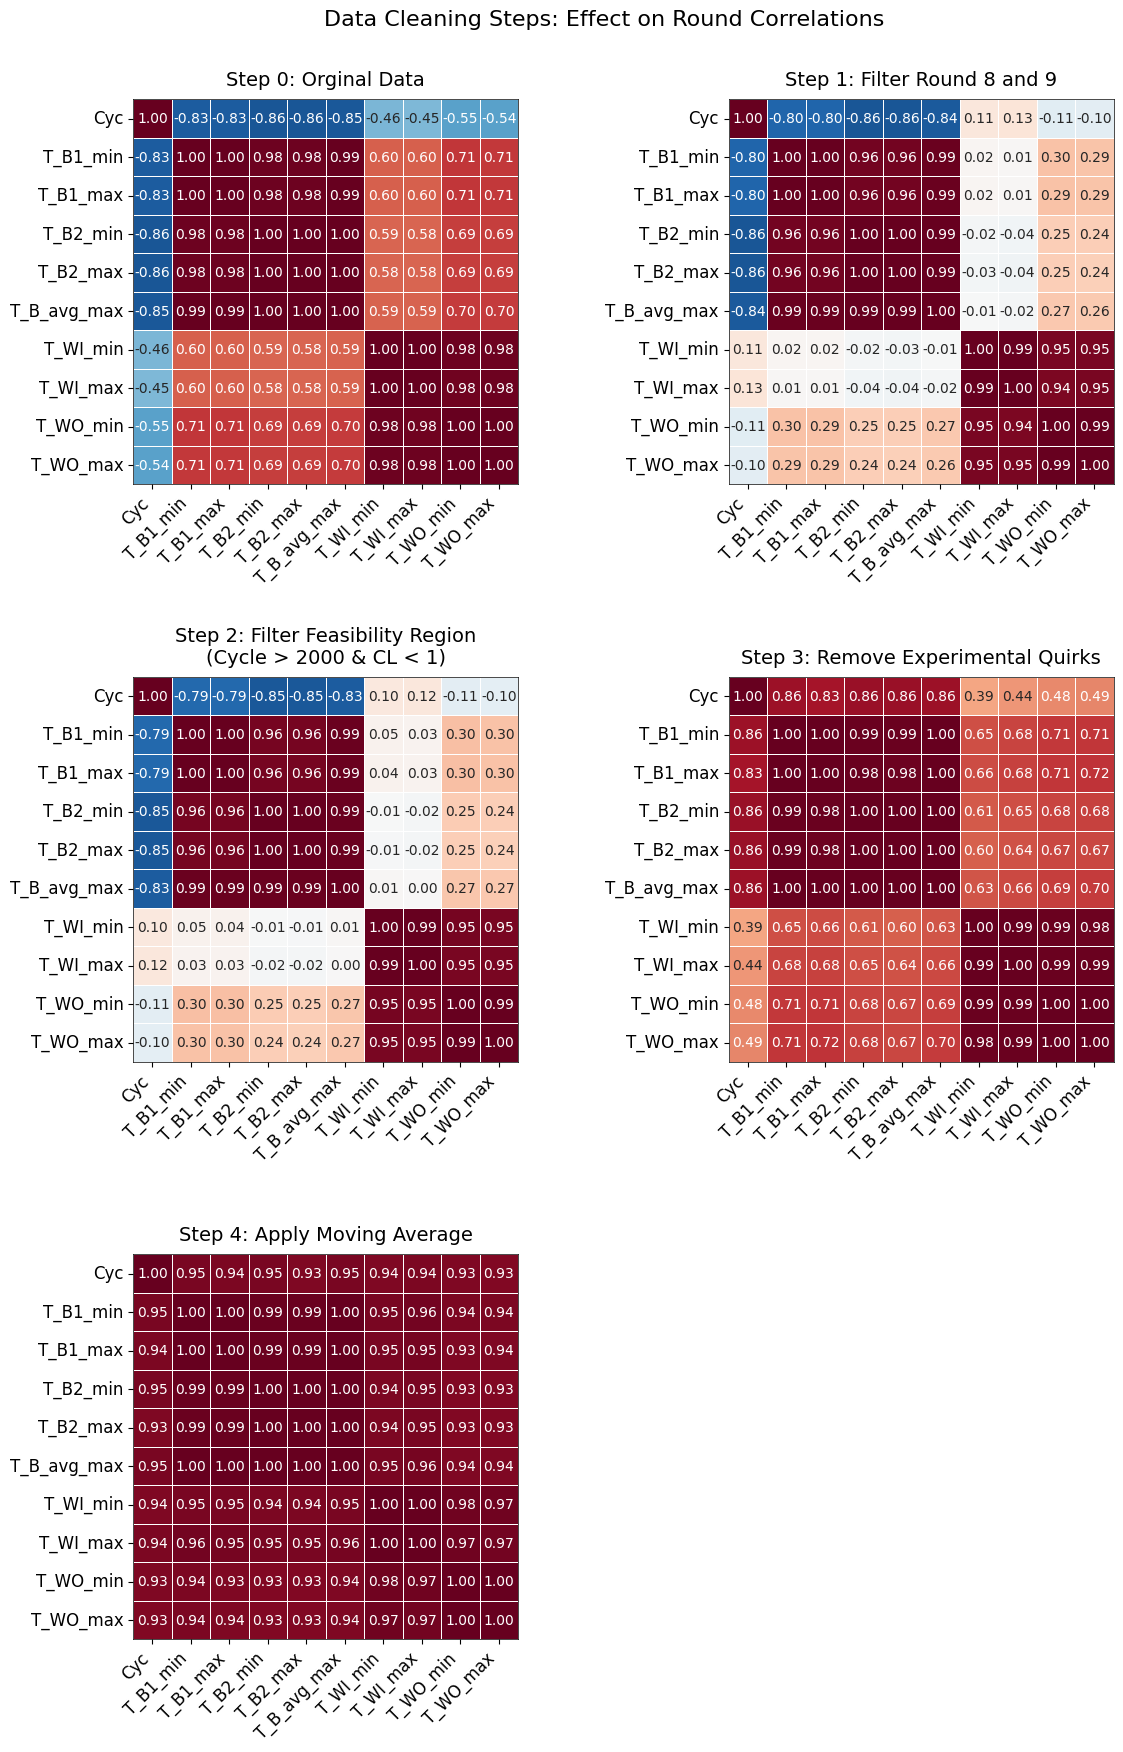

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_temperature_comparison(corr1, corr2, corr3, corr4, corr5, temp_properties, figsize=(15, 20)):
    """
    Create a publication-ready comparison of 5 temperature correlation matrices in a 3x2 grid layout.
    Plots are arranged row by row: (0,0), (0,1), (1,0), (1,1), (2,0)
    
    Parameters:
    - corr1, corr2, corr3, corr4, corr5 (pd.DataFrame): Correlation matrices to plot.
    - temp_properties (list): List of properties to include in the heatmap.
    - figsize (tuple): Figure size for the plot.
    
    Returns:
    - fig, axes: The figure and axes objects of the plot.
    """
    # Setup the figure with 3x2 grid layout with reduced spacing
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, hspace=0.5, wspace=0.05)
    
    # Create axes in row-major order
    axes_positions = [(0,0), (0,1), (1,0), (1,1), (2,0)]
    axes = []
    for i, j in axes_positions:
        axes.append(fig.add_subplot(gs[i, j]))
    
    matrices = [corr1, corr2, corr3, corr4, corr5]


    titles = [
        'Step 0: Orginal Data',
        'Step 1: Filter Round 8 and 9',
        'Step 2: Filter Feasibility Region\n(Cycle > 2000 & CL < 1)',
        'Step 3: Remove Experimental Quirks',
        'Step 4: Apply Moving Average'
    ]
    
    # Common heatmap parameters
    base_params = {
        'annot': True,
        'fmt': '.2f',
        'square': True,
        'linewidths': 0.5,
        'annot_kws': {'size': 10},
        'cmap': 'RdBu_r',
        'vmin': -1.0,
        'vmax': 1.0,
        'cbar': False  # No color bars
    }
    
    # Plot heatmaps
    for idx, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axes[idx]
        matrix_subset = matrix.loc[temp_properties, temp_properties]
        sns.heatmap(matrix_subset, ax=ax, **base_params)
        
        # Customize axes
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
        ax.set_title(title, fontsize=14, pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Customize spines
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)
            spine.set_visible(True)
    
    
    # Add main title
    fig.suptitle('Data Cleaning Steps: Effect on Round Correlations', y=0.925, fontsize=16)
    
    return fig, axes

# Example usage
temp_properties = ['Cyc', 'T_B1_min', 'T_B1_max', 'T_B2_min', 'T_B2_max',
                  'T_B_avg_max', 'T_WI_min', 'T_WI_max', 'T_WO_min', 'T_WO_max']

# Assuming the correlation matrices are already defined:
fig, axes = plot_temperature_comparison(
    mean_corr_df_2,
    mean_corr_df_8_and_9_2,
    mean_corr_df_feasible_r_2,
    mean_corr_df_no_mavg_2,
    mean_corr_df_new_2,
    temp_properties
)

# Save the plot as a high-resolution PNG
fig.savefig('Cleaning_Steps_Round_Correlations', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\3772593790.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


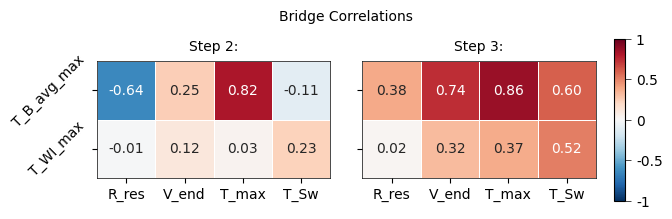

In [19]:
def plot_correlation_subset_comparison(corr1, corr2, rows_of_interest, cols_of_interest, figsize=None):
   """
   Create a publication-ready comparison of correlation matrix subsets optimized for A4 text width.
   """
   # A4 text width (160mm ≈ 6.3 inches)
   TEXT_WIDTH_INCHES = 7 # vad text wdith ska vara i mitt papper
   
   if figsize is None:
       width = TEXT_WIDTH_INCHES
       height = width * 0.3  # Increased height ratio to give more vertical space
       figsize = (width, height)
   
   # Optimized font sizes for A4 width
   MAIN_TITLE_SIZE = 10
   SUBTITLE_SIZE = 10
   TICK_LABEL_SIZE = 10
   ANNOTATION_SIZE = 10
   
   fig, axes = plt.subplots(1, 3, figsize=figsize, gridspec_kw={
       'width_ratios': [1, 1, 0.05],
       'wspace': 0.2,  # Reduced spacing to use space more efficiently
       'hspace': 0
   })
   
   # Subset and transpose the correlation matrices
   corr1_subset = corr1.loc[rows_of_interest, cols_of_interest].T
   corr2_subset = corr2.loc[rows_of_interest, cols_of_interest].T
   
   base_params = {
       'annot': True,
       'fmt': '.2f',
       'square': True,
       'linewidths': 0.5,
       'annot_kws': {'size': ANNOTATION_SIZE},
       'cmap': 'RdBu_r',
       'vmin': -1.0,
       'vmax': 1.0,
       'cbar': False
   }
   
   # Plot heatmaps
   sns.heatmap(corr1_subset, ax=axes[0], **base_params)
   sns.heatmap(corr2_subset, ax=axes[1], **base_params)
   
   # Customize axes
   titles = [
       'Step 2:',
       'Step 3:'
   ]
   
   # Modified axis customization loop to only show y-labels for first plot
   for idx, (ax, title) in enumerate(zip(axes[:2], titles)):
       ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=TICK_LABEL_SIZE)
       
       # Only show y-labels for the first (leftmost) plot
       if idx == 0:
           ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right', va='center', fontsize=TICK_LABEL_SIZE)
       else:
           ax.set_yticklabels([])  # Hide y-labels for other plots
           
       ax.set_title(title, fontsize=SUBTITLE_SIZE, pad=8)
       ax.set_xlabel('')
       ax.set_ylabel('')
       ax.set_aspect('equal')
       
       for spine in ax.spines.values():
           spine.set_linewidth(0.5)
           spine.set_visible(True)
   
   # Optimized colorbar
   norm = plt.Normalize(vmin=-1, vmax=1)
   cbar = ColorbarBase(axes[2], cmap=plt.get_cmap('RdBu_r'), norm=norm)
   cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
   cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1'])
   cbar.ax.tick_params(labelsize=TICK_LABEL_SIZE, length=4, width=0.5)
   
   # Improved colorbar positioning
   pos = axes[2].get_position()
   axes[2].set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])
   
   # Title positioning
   left_pos = axes[0].get_position()
   right_pos = axes[1].get_position()
   center_x = (left_pos.x0 + right_pos.x1) / 2
   
   fig.suptitle('Bridge Correlations', x=center_x, y=1.02, fontsize=MAIN_TITLE_SIZE)
   
   plt.tight_layout()
   
   return fig, axes

# Usage:
rows_of_interest = ['R_res', 'V_end', 'T_max', 'T_Sw']
cols_of_interest = ['T_B_avg_max', 'T_WI_max']

fig, axes = plot_correlation_subset_comparison(
   mean_corr_df_feasible_r,
   mean_corr_df_no_mavg,
   rows_of_interest,
   cols_of_interest
)
fig.savefig('Bridge_Correlations.png', dpi=300, bbox_inches='tight')
plt.show()

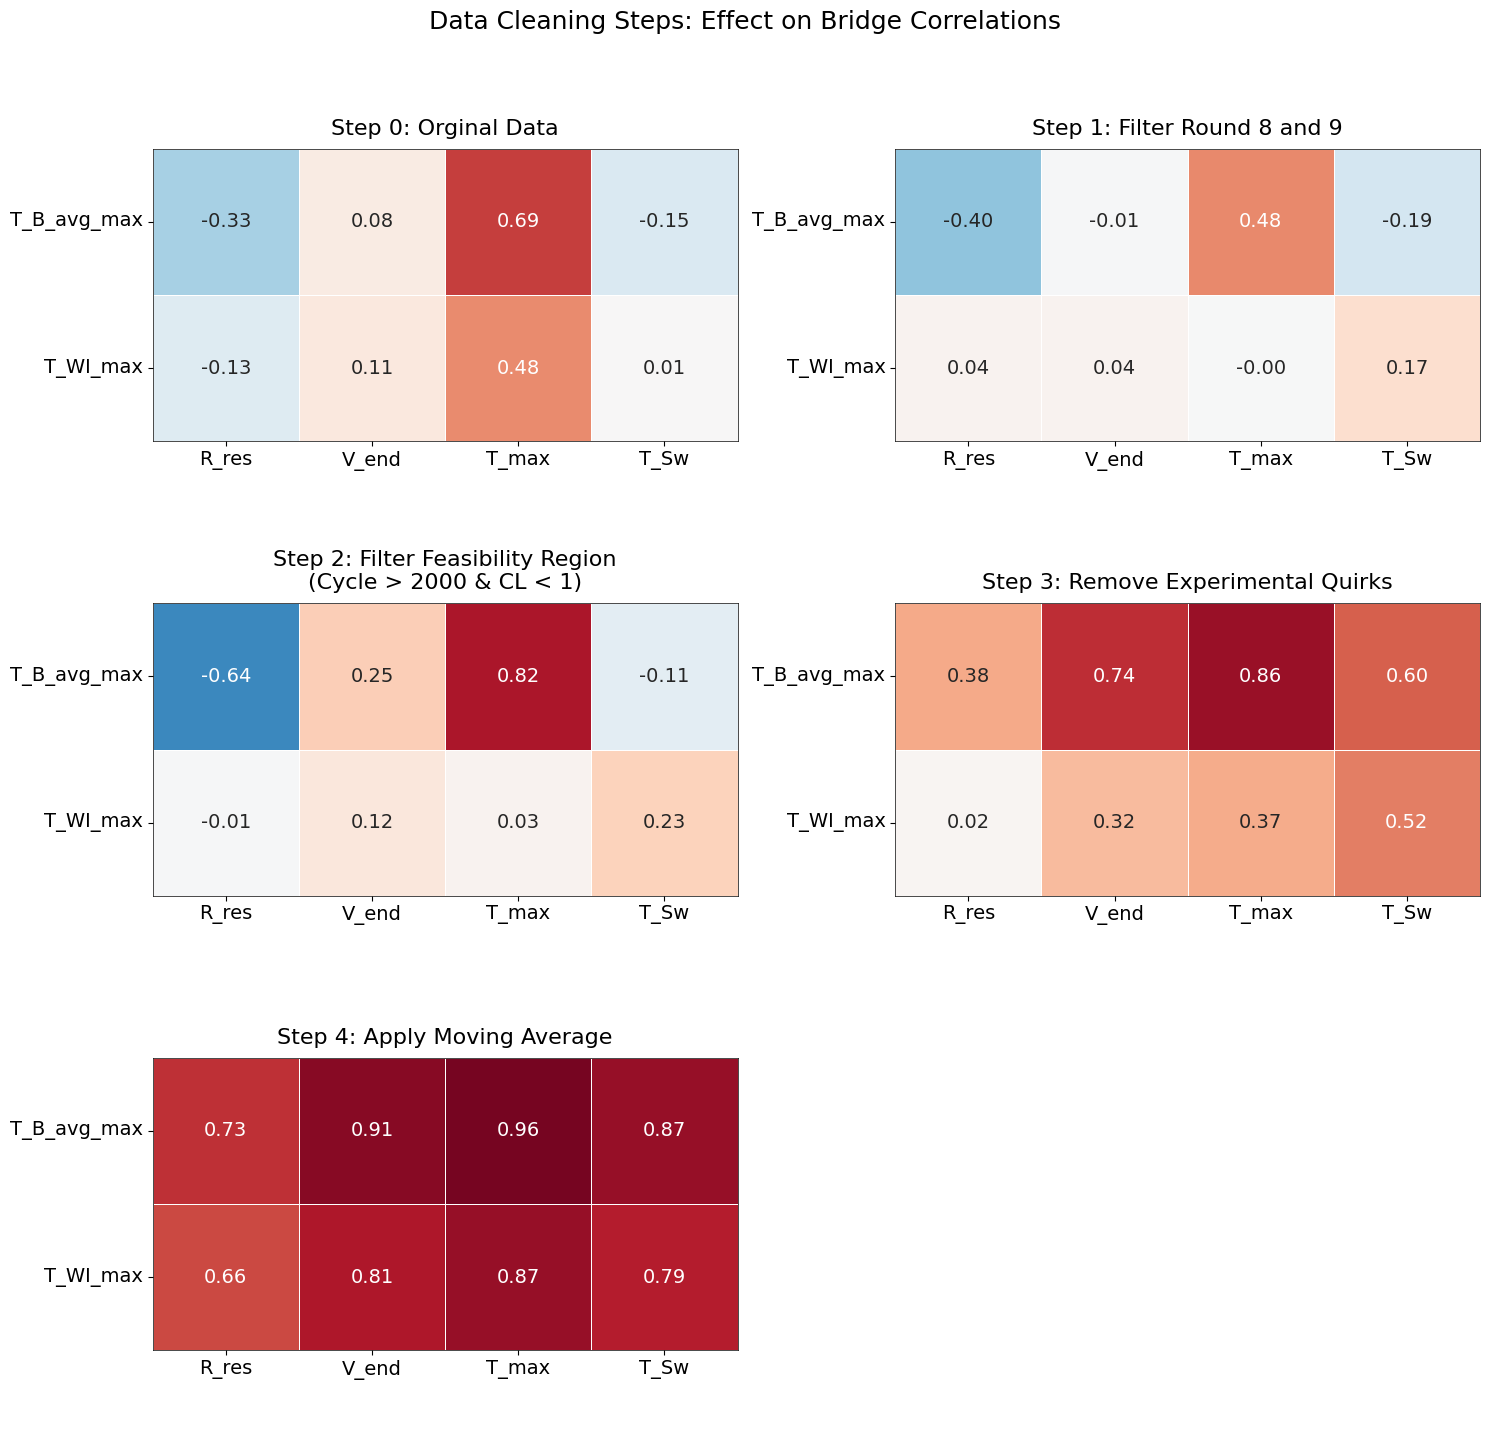

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_subset_comparison(corr1, corr2, corr3, corr4, corr5, rows_of_interest, cols_of_interest, figsize=(15, 15)):
    """
    Create a publication-ready comparison of correlation matrix subsets for 5 DataFrames.

    Parameters:
    - corr1, corr2, corr3, corr4, corr5 (pd.DataFrame): Correlation matrices to compare.
    - rows_of_interest (list): Rows of interest for the subset.
    - cols_of_interest (list): Columns of interest for the subset.
    - figsize (tuple): Size of the figure.

    Returns:
    - fig, axes: The figure and axes objects of the plot.
    """
    # Subset and transpose the correlation matrices
    corr1_subset = corr1.loc[rows_of_interest, cols_of_interest].T
    corr2_subset = corr2.loc[rows_of_interest, cols_of_interest].T
    corr3_subset = corr3.loc[rows_of_interest, cols_of_interest].T
    corr4_subset = corr4.loc[rows_of_interest, cols_of_interest].T
    corr5_subset = corr5.loc[rows_of_interest, cols_of_interest].T

    # Setup the figure with a 3x2 grid layout (5 plots with 6th slot left blank)
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    axes = axes.flatten()  # Flatten for easy iteration
    matrices = [corr1_subset, corr2_subset, corr3_subset, corr4_subset, corr5_subset]
    titles = [
        'Step 0: Orginal Data',
        'Step 1: Filter Round 8 and 9',
        'Step 2: Filter Feasibility Region\n(Cycle > 2000 & CL < 1)',
        'Step 3: Remove Experimental Quirks',
        'Step 4: Apply Moving Average'
    ]

    # Common base parameters
    base_params = {
        'annot': True,
        'fmt': '.2f',
        'square': True,
        'linewidths': 0.5,
        'annot_kws': {'size': 14},
        'cmap': 'RdBu_r',
        'vmin': -1.0,
        'vmax': 1.0,
        'cbar': False  # No color bars
    }

    # Plot heatmaps for the first 5 matrices
    for ax, matrix, title in zip(axes[:5], matrices, titles):
        sns.heatmap(matrix, ax=ax, **base_params)

        # Customize axes
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=14)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
        ax.set_title(title, fontsize=16, pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Customize spines
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)
            spine.set_visible(True)

    # Leave the last subplot blank
    axes[5].axis('off')

    # Add main title
    fig.suptitle('Data Cleaning Steps: Effect on Bridge Correlations', y=0.95, fontsize=18)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space at top for the title

    return fig, axes

# Example usage
rows_of_interest = ['R_res', 'V_end', 'T_max', 'T_Sw']
cols_of_interest = ['T_B_avg_max', 'T_WI_max']

# Assuming the correlation matrices are already defined:
fig, axes = plot_correlation_subset_comparison(
    mean_corr_df,
    mean_corr_df_8_and_9,
    mean_corr_df_feasible_r,
    mean_corr_df_no_mavg,
    mean_corr_df_new,
    rows_of_interest,
    cols_of_interest
)

# Save the plot as a high-resolution PNG
fig.savefig('Cleaning_Steps_Bridge_Correlations', dpi=300, bbox_inches='tight')
plt.show()


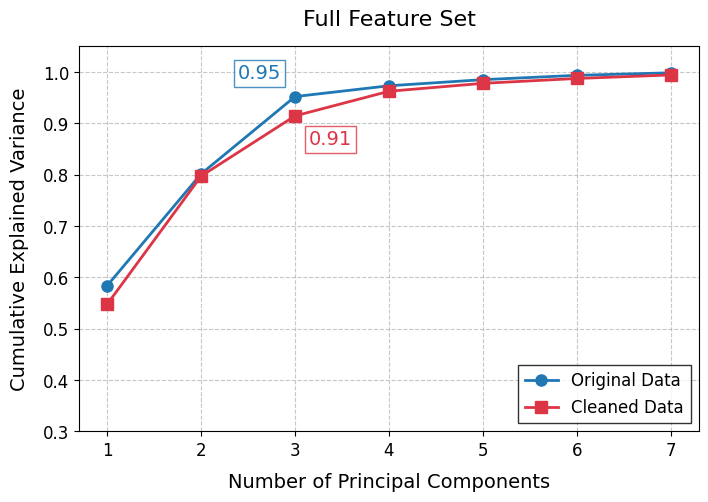

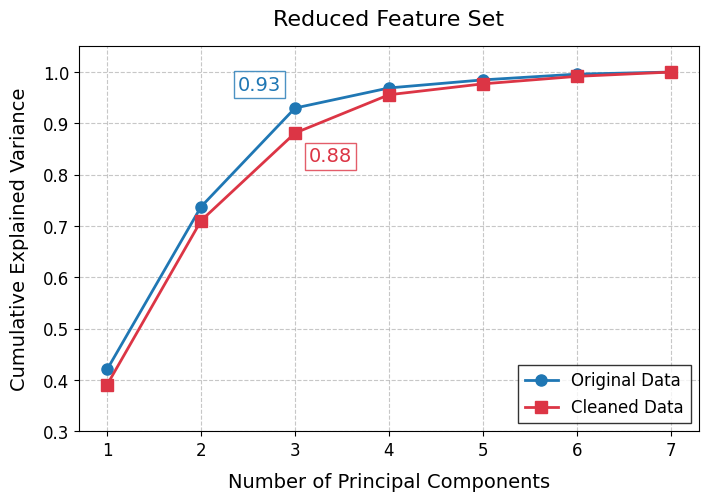

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def perform_pca_comparison(df_original, df_new, n_components=None):
    """
    Perform PCA on two DataFrames with both full and reduced feature sets.

    Parameters:
    - df_original (pd.DataFrame): The original DataFrame
    - df_new (pd.DataFrame): The new DataFrame
    - n_components (int): Number of PCA components to keep

    Returns:
    - tuple: (pca_original, pca_new, pca_original_reduced, pca_new_reduced,
             df_cleaned_original, df_cleaned_new, df_cleaned_original_reduced, df_cleaned_new_reduced)
    """
    def create_pca_plot(cumulative_variance_original, cumulative_variance_new, title_suffix, filename):
        color_original = '#1f77b4'  # Blue
        color_new = '#dc3545'       # Red

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(cumulative_variance_original) + 1), 
                 cumulative_variance_original, 
                 marker='o', 
                 markersize=8,
                 linestyle='-', 
                 linewidth=2,
                 color=color_original, 
                 label='Original Data')
        plt.plot(range(1, len(cumulative_variance_new) + 1), 
                 cumulative_variance_new, 
                 marker='s', 
                 markersize=8,
                 linestyle='-', 
                 linewidth=2,
                 color=color_new, 
                 label='Cleaned Data')

        # Add annotations
        plt.annotate(f'{cumulative_variance_original[2]:.2f}', 
                     (3, cumulative_variance_original[2]),
                     textcoords="offset points",
                     xytext=(-10, 10),
                     ha='right',
                     va='bottom',
                     fontsize=14,
                     color=color_original,
                     bbox=dict(facecolor='white', 
                               edgecolor=color_original,
                               alpha=0.8,
                               pad=3))

        plt.annotate(f'{cumulative_variance_new[2]:.2f}', 
                     (3, cumulative_variance_new[2]),
                     textcoords="offset points",
                     xytext=(10, -10),
                     ha='left',
                     va='top',
                     fontsize=14,
                     color=color_new,
                     bbox=dict(facecolor='white', 
                               edgecolor=color_new,
                               alpha=0.8,
                               pad=3))

        plt.title(f'{title_suffix}', fontsize=16, pad=15)
        plt.xlabel('Number of Principal Components', fontsize=14, labelpad=10)
        plt.ylabel('Cumulative Explained Variance', fontsize=14, labelpad=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(range(1, len(cumulative_variance_original) + 1), fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylim(0.3, 1.05)
        plt.legend(fontsize=12, frameon=True, fancybox=False, edgecolor='black', loc='lower right')

        # Save and show the figure
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()

    # Define columns to drop
    columns_to_drop_full = ['device', 'round', 'consumed_life', 'end_voltage']
    columns_to_drop_reduced = columns_to_drop_full + [
        'max_block_temperature_1', 'min_block_temperature_1', 'min_block_temperature_2',
        'max_block_temperature_2', 'min_water_inlet_temperature', 'max_water_inlet_temperature',
        'min_water_outlet_temperature', 'min_temperature', 'end_resistance_residual_cleaned', 'consumed_life'
    ]

    # Process full feature set
    df_cleaned_original = df_original.drop(columns_to_drop_full, axis=1)
    df_cleaned_new = df_new.drop(columns_to_drop_full, axis=1)

    # Process reduced feature set
    df_cleaned_original_reduced = df_original.drop(columns_to_drop_reduced, axis=1)
    df_cleaned_new_reduced = df_new.drop(columns_to_drop_reduced, axis=1)

    # Standardize data
    scaler = StandardScaler()
    standardized_data = {
        'full_original': scaler.fit_transform(df_cleaned_original),
        'full_new': scaler.fit_transform(df_cleaned_new),
        'reduced_original': scaler.fit_transform(df_cleaned_original_reduced),
        'reduced_new': scaler.fit_transform(df_cleaned_new_reduced)
    }

    # Full feature set PCA
    pca_full_original = PCA(n_components=7).fit(standardized_data['full_original'])
    pca_full_new = PCA(n_components=7).fit(standardized_data['full_new'])

    # Reduced feature set PCA
    pca_reduced_original = PCA(n_components=7).fit(standardized_data['reduced_original'])
    pca_reduced_new = PCA(n_components=7).fit(standardized_data['reduced_new'])

    # Plot full feature set
    create_pca_plot(
        pca_full_original.explained_variance_ratio_.cumsum(),
        pca_full_new.explained_variance_ratio_.cumsum(),
        "Full Feature Set",
        "Cumulative_Explained_Variance_Full.png"
    )

    # Plot reduced feature set
    create_pca_plot(
        pca_reduced_original.explained_variance_ratio_.cumsum(),
        pca_reduced_new.explained_variance_ratio_.cumsum(),
        "Reduced Feature Set",
        "Cumulative_Explained_Variance_Reduced.png"
    )

    # Return all PCA objects and cleaned DataFrames
    return (PCA(n_components=n_components).fit(standardized_data['full_original']),
            PCA(n_components=n_components).fit(standardized_data['full_new']),
            PCA(n_components=n_components).fit(standardized_data['reduced_original']),
            PCA(n_components=n_components).fit(standardized_data['reduced_new']),
            df_cleaned_original,
            df_cleaned_new,
            df_cleaned_original_reduced,
            df_cleaned_new_reduced)

# Usage
results = perform_pca_comparison(df, df_new, n_components=3)
pca_original, pca_new, pca_original_reduced, pca_new_reduced = results[:4]
df_cleaned_original, df_cleaned_new, df_cleaned_original_reduced, df_cleaned_new_reduced = results[4:]



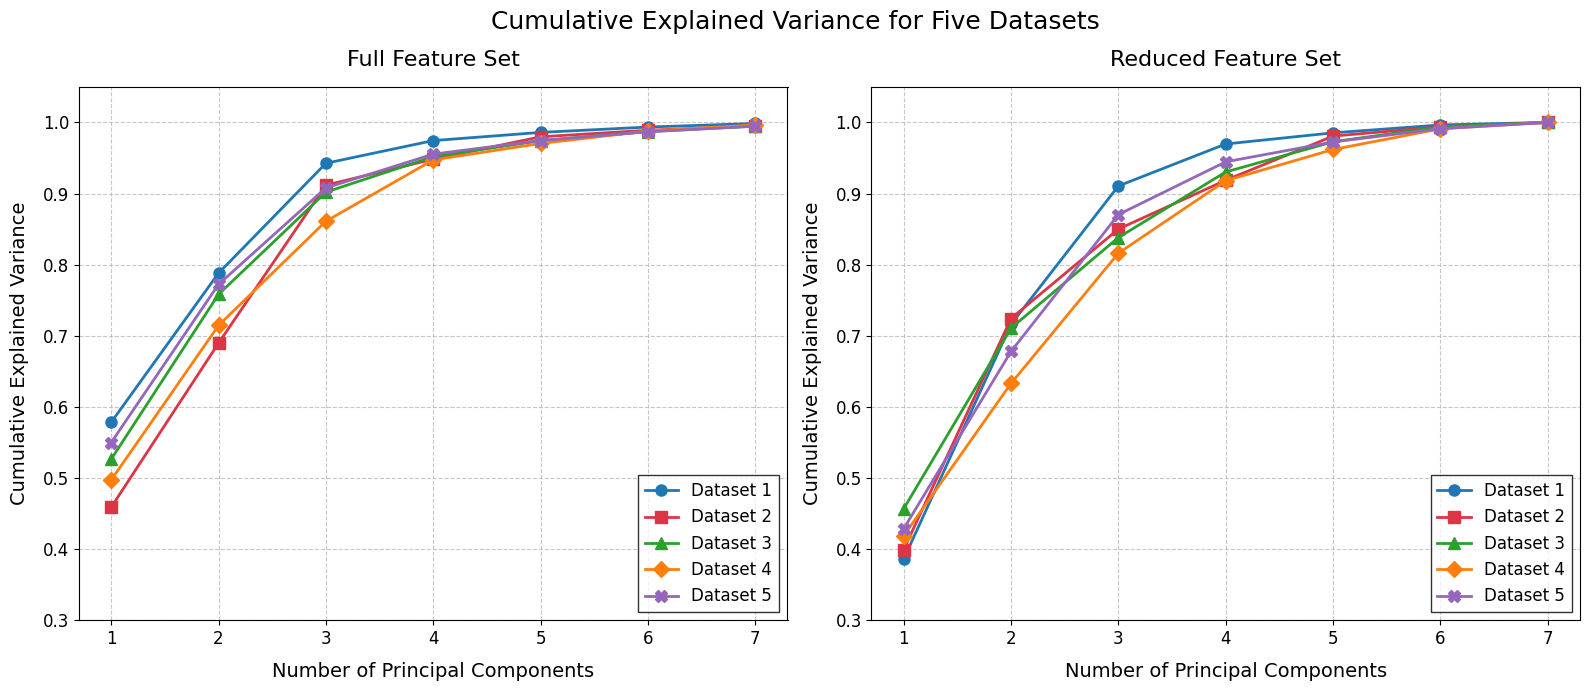

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def perform_pca_comparison(df1, df2, df3, df4, df5, n_components=None):
    """
    Perform PCA on five DataFrames with both full and reduced feature sets.

    Parameters:
    - df1, df2, df3, df4, df5 (pd.DataFrame): DataFrames to analyze
    - n_components (int): Number of PCA components to keep

    Returns:
    - tuple: PCA objects and cleaned DataFrames for both full and reduced feature sets
    """
    def create_pca_plot(cumulative_variance_list, titles, title_suffix):
        colors = ['#1f77b4', '#dc3545', '#2ca02c', '#ff7f0e', '#9467bd']  # Different colors for each dataset
        markers = ['o', 's', '^', 'D', 'X']  # Different markers for each dataset
        
        for i, (cumulative_variance, title, color, marker) in enumerate(zip(cumulative_variance_list, titles, colors, markers)):
            plt.plot(range(1, len(cumulative_variance) + 1), 
                     cumulative_variance, 
                     marker=marker, 
                     markersize=8,
                     linestyle='-', 
                     linewidth=2,
                     color=color, 
                     label=title)

        plt.title(f'{title_suffix}', fontsize=16, pad=15)
        plt.xlabel('Number of Principal Components', fontsize=14, labelpad=10)
        plt.ylabel('Cumulative Explained Variance', fontsize=14, labelpad=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(range(1, len(cumulative_variance_list[0]) + 1), fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylim(0.3, 1.05)
        plt.legend(fontsize=12, frameon=True, fancybox=False, edgecolor='black', loc='lower right')

    # Define columns to drop
    columns_to_drop_full = ['device', 'round', 'cycle', 'end_voltage']
    columns_to_drop_reduced = columns_to_drop_full + [
        'max_block_temperature_1', 'min_block_temperature_1', 'min_block_temperature_2',
        'max_block_temperature_2', 'min_water_inlet_temperature', 'max_water_inlet_temperature',
        'min_water_outlet_temperature', 'min_temperature', 'end_resistance_residual_cleaned'
    ]

    # Process full feature set
    dfs_cleaned_full = [df.drop(columns_to_drop_full, axis=1) for df in [df1, df2, df3, df4, df5]]
    
    # Process reduced feature set
    dfs_cleaned_reduced = [df.drop(columns_to_drop_reduced, axis=1) for df in [df1, df2, df3, df4, df5]]
    
    # Standardize data
    scaler = StandardScaler()
    standardized_data_full = [scaler.fit_transform(df) for df in dfs_cleaned_full]
    standardized_data_reduced = [scaler.fit_transform(df) for df in dfs_cleaned_reduced]

    # Titles for each dataset
    titles = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4', 'Dataset 5']

    # Full feature set PCA
    pca_full = [PCA(n_components=7).fit(data) for data in standardized_data_full]
    cumulative_variance_full = [pca.explained_variance_ratio_.cumsum() for pca in pca_full]
    
    # Reduced feature set PCA
    pca_reduced = [PCA(n_components=7).fit(data) for data in standardized_data_reduced]
    cumulative_variance_reduced = [pca.explained_variance_ratio_.cumsum() for pca in pca_reduced]

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Plot full feature set
    plt.sca(ax1)
    create_pca_plot(cumulative_variance_full, titles, "Full Feature Set")

    # Plot reduced feature set
    plt.sca(ax2)
    create_pca_plot(cumulative_variance_reduced, titles, "Reduced Feature Set")

    plt.suptitle('Cumulative Explained Variance for Five Datasets', fontsize=18)

    # Adjust layout
    plt.tight_layout()

    # Save figure with high resolution
    fig.savefig('Cumulative_Explained_Variance_Five_Datasets.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    plt.show()

    # Return all PCA objects and cleaned DataFrames
    return (pca_full, pca_reduced, dfs_cleaned_full, dfs_cleaned_reduced)

results = perform_pca_comparison(df, df_8_and_9, df_feasible_r, df_no_mavg, df_new, n_components=3)
pca_full, pca_reduced, dfs_cleaned_full, dfs_cleaned_reduced = results



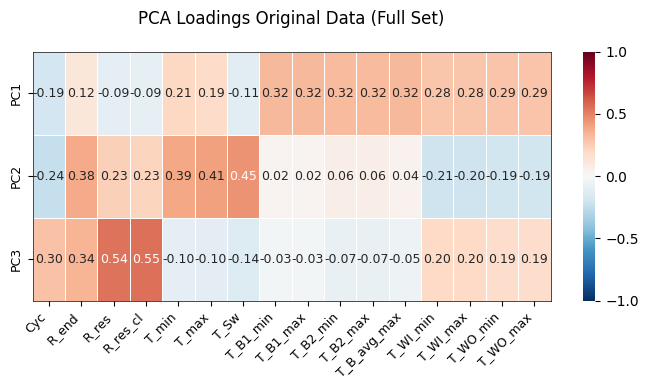

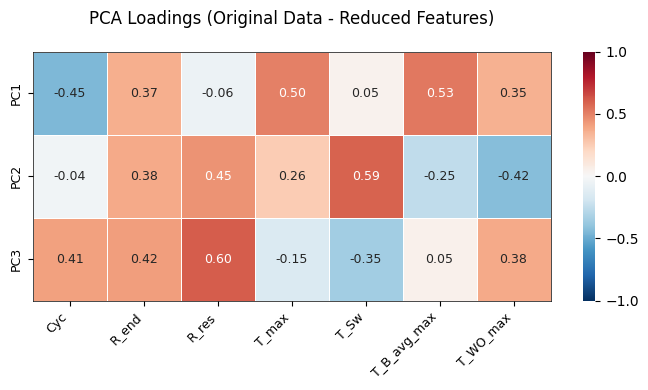

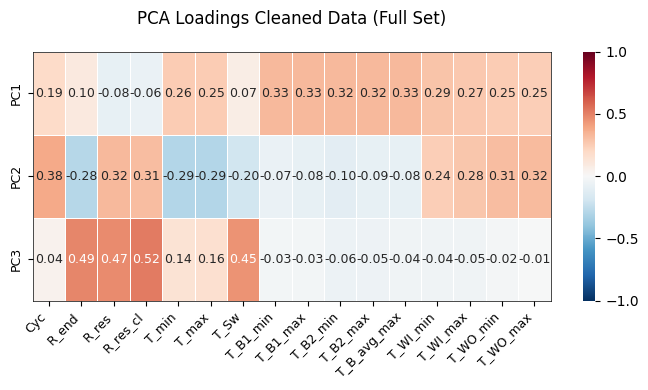

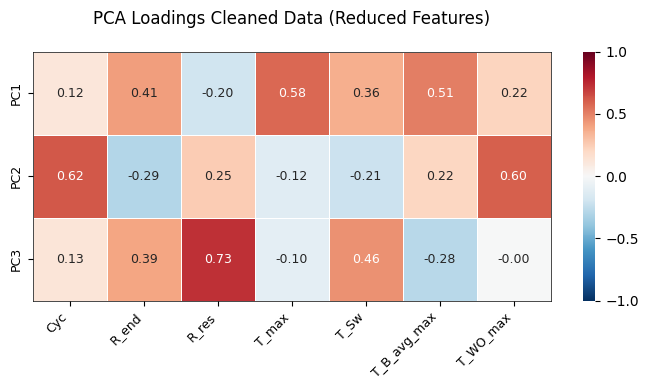

In [39]:
def plot_pca_loadings(pca, standardized_df, abbreviations=None, title_suffix="", save_name=None):
   """
   Plot a publication-ready heatmap of PCA feature loadings.
   
   Parameters:
   - pca: The fitted PCA object
   - standardized_df: The standardized DataFrame used for PCA
   - abbreviations: Optional dictionary to rename the feature columns
   - title_suffix: Optional string to append to the title to differentiate plots
   - save_name: Optional string for output filename. If None, figure is not saved
   """
   # Create the pca_loadings DataFrame
   pca_loadings = pd.DataFrame(
       pca.components_,
       columns=standardized_df.columns,
       index=[f"PC{i+1}" for i in range(pca.n_components_)]
   )
   
   # Rename columns if abbreviations provided
   if abbreviations:
       pca_loadings = pca_loadings.rename(columns=abbreviations)
   
   # Create figure with specific size
   fig, ax = plt.subplots(figsize=(7, 4))
   
   # Create heatmap with improved styling
   sns.heatmap(
       pca_loadings,
       annot=True,
       fmt='.2f',
       cmap='RdBu_r',
       center=0,
       vmin=-1,
       vmax=1,
       linewidths=0.5,
       annot_kws={"size": 9},
       cbar_kws={
            'ticks': [-1, -0.5, 0, 0.5, 1]  }  # Set specific tick values
   ) 
   
   # Customize plot
   ax.set_title(f'PCA Loadings{title_suffix}',
               pad=20,
               fontsize=12)
   
   # Adjust tick labels
   plt.xticks(rotation=45, ha='right', fontsize=9)
   plt.yticks(fontsize=9)
   
   # Add thin borders
   for spine in ax.spines.values():
       spine.set_linewidth(0.5)
       spine.set_visible(True)
   
   # Adjust layout
   plt.tight_layout()
   
   # Save figure only if save_name is provided
   if save_name is not None:
       plt.savefig(save_name,
                  dpi=300,
                  bbox_inches='tight',
                  facecolor='white',
                  edgecolor='none')
   
   plt.show()


# Plot all four versions with appropriate titles
plot_pca_loadings(pca_original, df_cleaned_original, 
                  abbreviations=abbreviations,
                  title_suffix=" Original Data (Full Set)", save_name='original_pca_loadings_full.png')

plot_pca_loadings(pca_original_reduced, df_cleaned_original_reduced, 
                  abbreviations=abbreviations,
                  title_suffix=" (Original Data - Reduced Features)",
                   save_name='original_pca_loadings.png')

plot_pca_loadings(pca_new, df_cleaned_new, 
                  abbreviations=abbreviations,
                  title_suffix=" Cleaned Data (Full Set)", save_name='cleaned_pca_loadings_full.png')

plot_pca_loadings(pca_new_reduced, df_cleaned_new_reduced, 
                  abbreviations=abbreviations,
                  title_suffix=" Cleaned Data (Reduced Features)",
                  save_name='Cleaned_pca_loadings.png')

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_17260\3666300195.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 700x560 with 3 Axes>,
 (<Axes: title={'center': 'Original Data'}>,
  <Axes: title={'center': 'After Cleaning'}>))

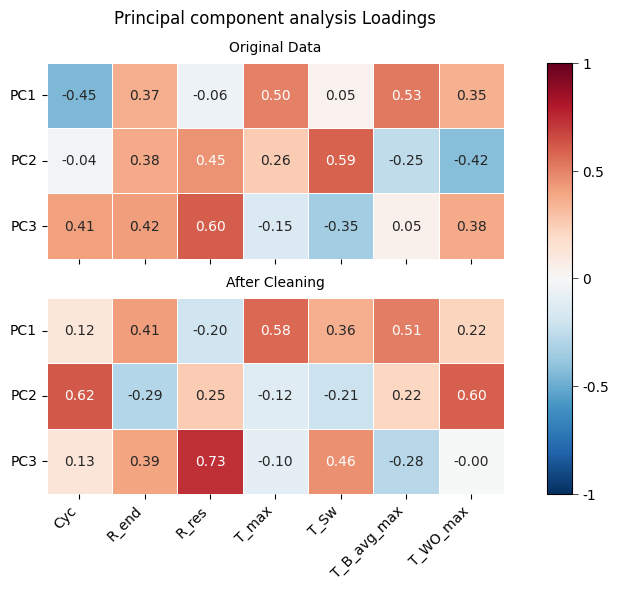

In [30]:
def plot_pca_loadings_comparison(pca_original, pca_cleaned, standardized_df_original, standardized_df_cleaned, 
                                 abbreviations=None, title_suffix="", save_name=None):
    """
    Create a publication-ready comparison of PCA feature loadings for original and cleaned data.
    """
    # A4 text width (160mm ≈ 6.3 inches)
    TEXT_WIDTH_INCHES = 7
    
    # Set figure size
    width = TEXT_WIDTH_INCHES
    height = width * 0.8  # Adjusted height for better layout proportions
    figsize = (width, height)
    
    # Optimized font sizes
    MAIN_TITLE_SIZE = 12
    SUBTITLE_SIZE = 10
    TICK_LABEL_SIZE = 10
    ANNOTATION_SIZE = 10
    
    # Create PCA loadings DataFrames
    pca_loadings_original = pd.DataFrame(
        pca_original.components_,
        columns=standardized_df_original.columns,
        index=[f"PC{i+1}" for i in range(pca_original.n_components_)]
    )
    pca_loadings_cleaned = pd.DataFrame(
        pca_cleaned.components_,
        columns=standardized_df_cleaned.columns,
        index=[f"PC{i+1}" for i in range(pca_cleaned.n_components_)]
    )
    
    if abbreviations:
        pca_loadings_original = pca_loadings_original.rename(columns=abbreviations)
        pca_loadings_cleaned = pca_loadings_cleaned.rename(columns=abbreviations)
    
    # Create figure with gridspec
    from matplotlib import gridspec
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.05], height_ratios=[1, 1], 
                           wspace=0.1, hspace=0.2)  # Adjusted spacing
    
    base_params = {
        'annot': True,
        'fmt': '.2f',
        'cmap': 'RdBu_r',
        'center': 0,
        'vmin': -1,
        'vmax': 1,
        'linewidths': 0.5,
        'annot_kws': {'size': ANNOTATION_SIZE},
        'cbar': False
    }
    
    # Plot original PCA loadings heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(pca_loadings_original, ax=ax1, **base_params)
    ax1.set_title('Original Data', fontsize=SUBTITLE_SIZE, pad=8)
    ax1.set_xticklabels([])
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=TICK_LABEL_SIZE)
    ax1.set_aspect('equal')
    
    # Plot cleaned PCA loadings heatmap
    ax2 = fig.add_subplot(gs[1, 0])
    sns.heatmap(pca_loadings_cleaned, ax=ax2, **base_params)
    ax2.set_title('After Cleaning', fontsize=SUBTITLE_SIZE, pad=8)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=TICK_LABEL_SIZE)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=TICK_LABEL_SIZE)
    ax2.set_aspect('equal')
    
    # Add shared colorbar
    cbar_ax = fig.add_subplot(gs[:, 1])
    norm = plt.Normalize(vmin=-1, vmax=1)
    cbar = ColorbarBase(cbar_ax, cmap='RdBu_r', norm=norm, orientation='vertical')
    cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
    cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1'])
    cbar.ax.tick_params(labelsize=TICK_LABEL_SIZE, length=4, width=0.5)
    


    fig.suptitle('Principal Component Loadings', fontsize=MAIN_TITLE_SIZE)

    # First do tight_layout to properly position all subplots
    plt.tight_layout()

    # After tight_layout, get the subplot positions and calculate center
    left_pos = ax1.get_position()
    right_pos = ax2.get_position()
    center_x = (left_pos.x0 + right_pos.x1) / 2

    # Update suptitle position after tight_layout
    fig.suptitle('Principal component analysis Loadings', x=center_x, y=0.975, fontsize=MAIN_TITLE_SIZE)
        

    
    if save_name:
        plt.savefig(save_name, dpi=300, bbox_inches='tight')
    
    return fig, (ax1, ax2)




plot_pca_loadings_comparison(
    pca_original=pca_original_reduced,
    pca_cleaned=pca_new_reduced,
    standardized_df_original=df_cleaned_original_reduced,
    standardized_df_cleaned=df_cleaned_new_reduced,
    abbreviations=abbreviations,
    title_suffix=" - Comparison",
    save_name='PCA_Loadings_Comparison_Aligned.png'
)

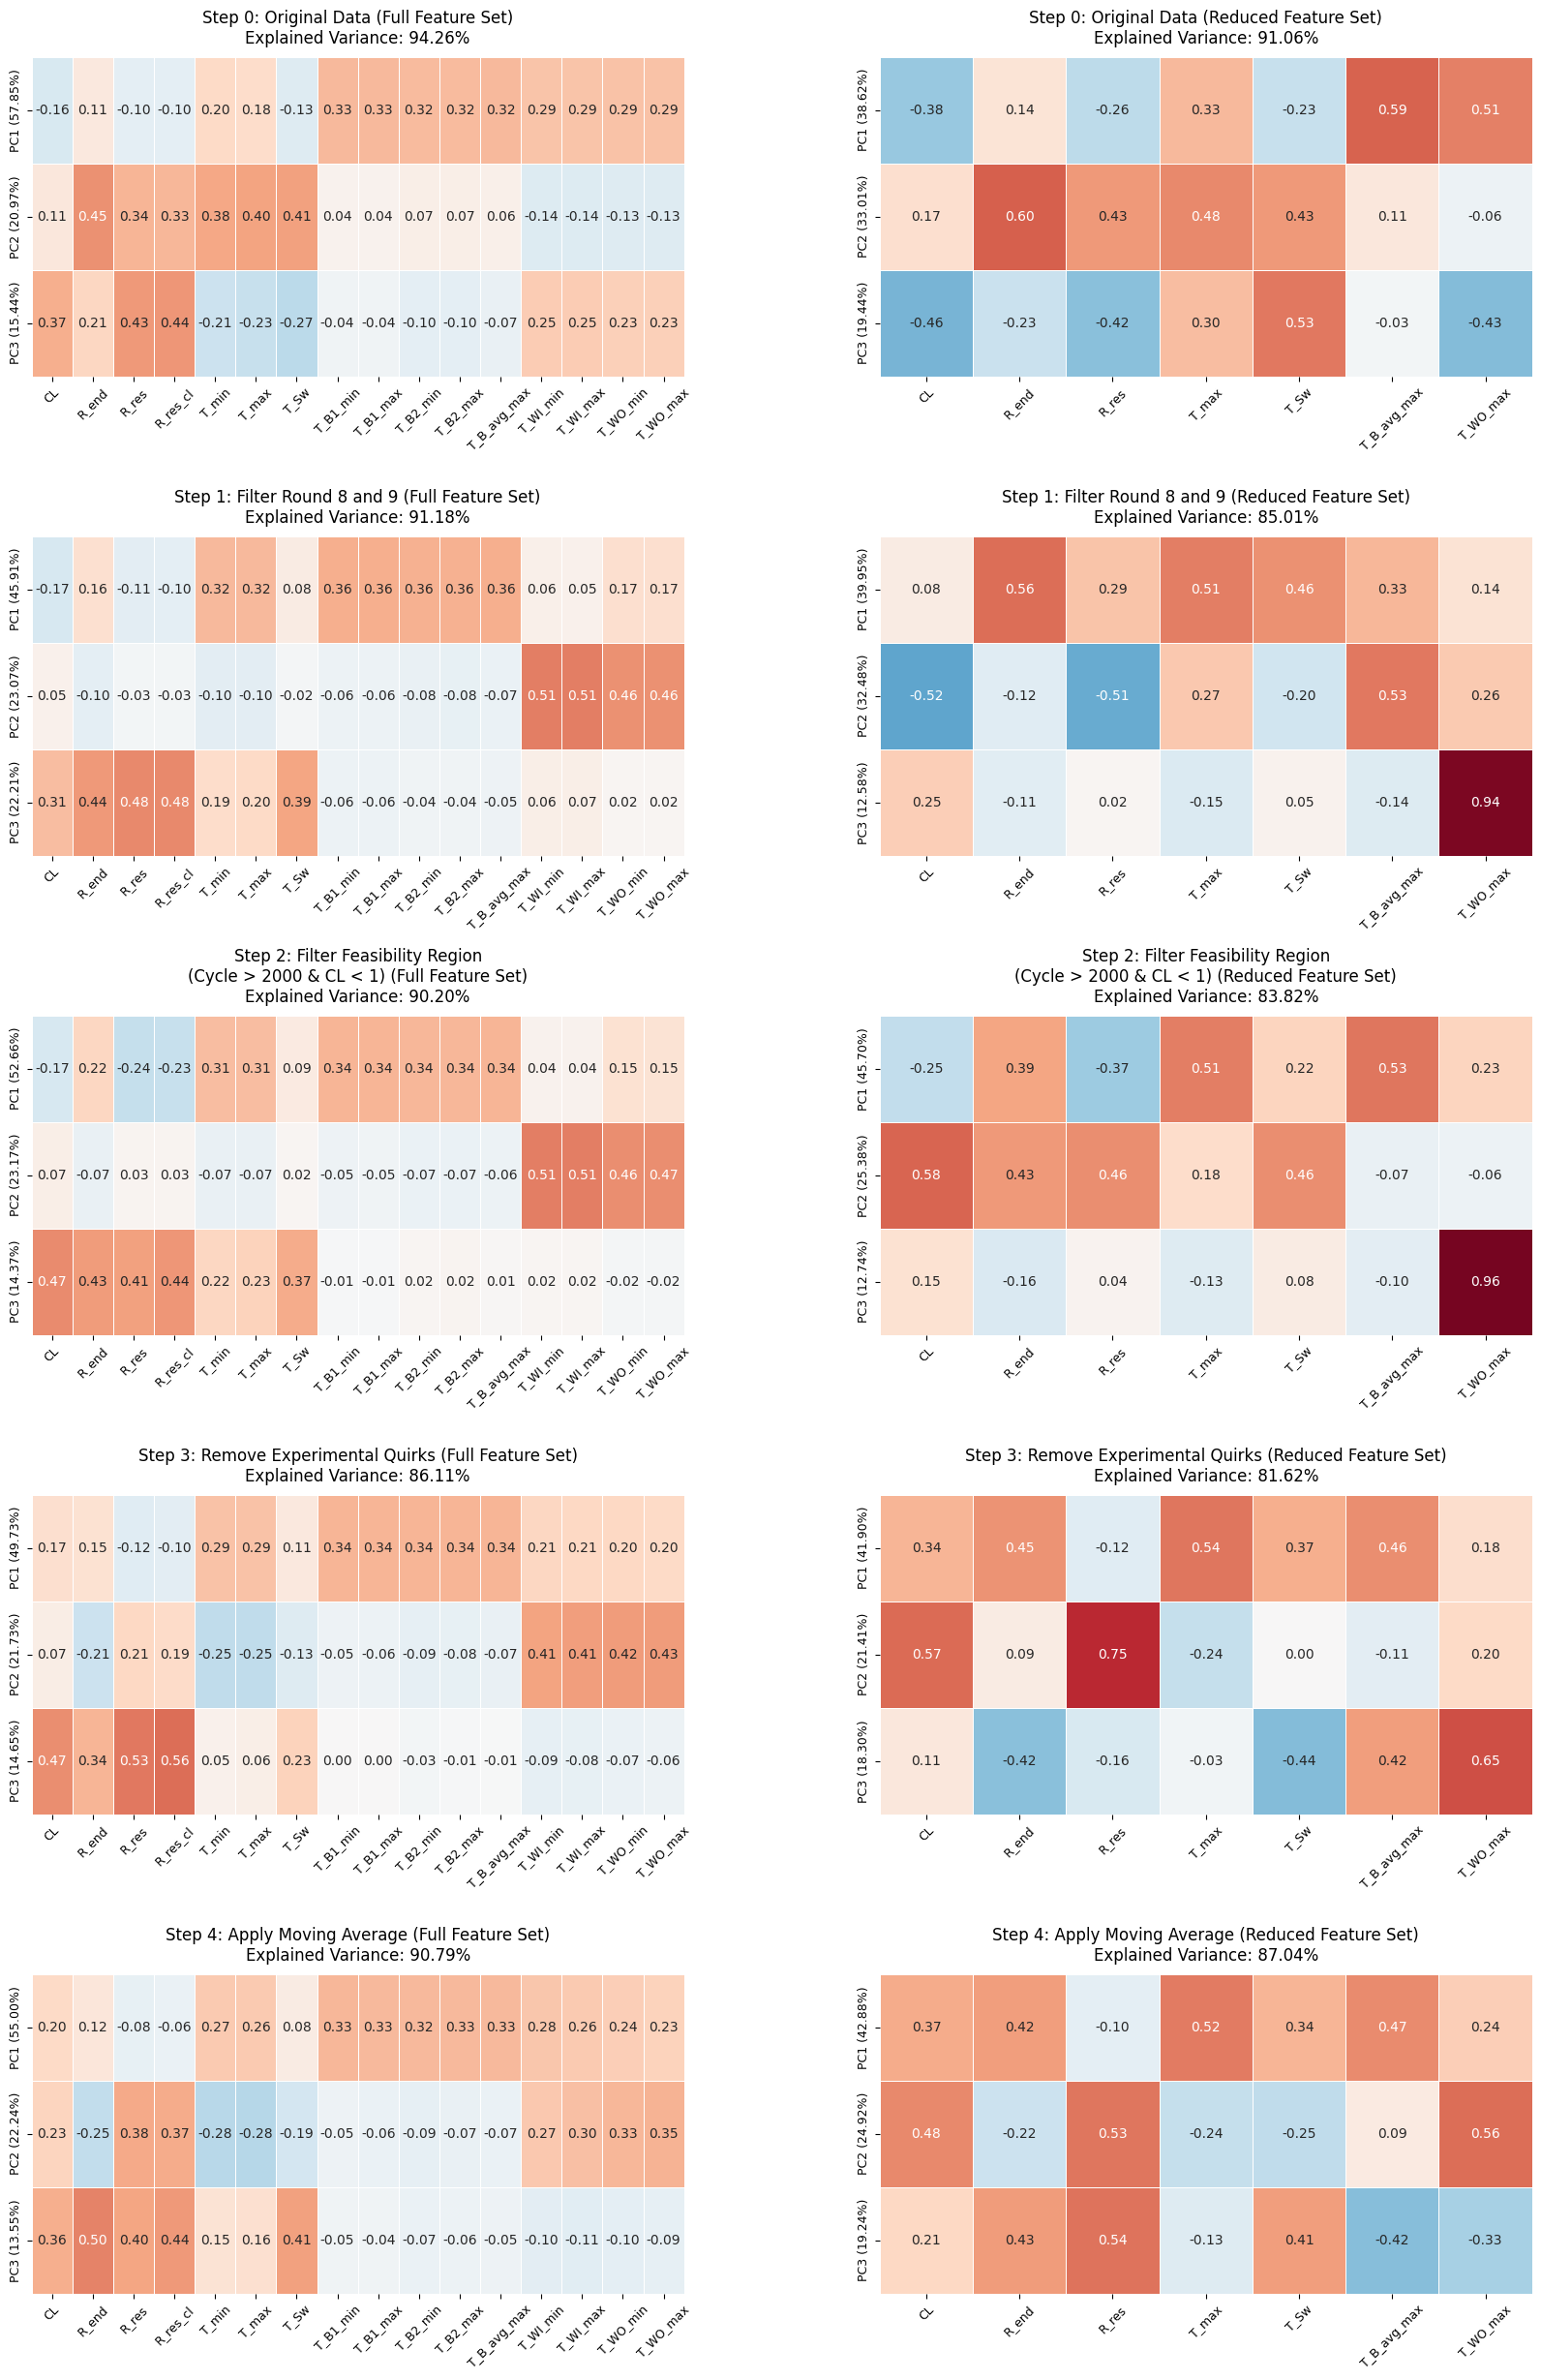

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec

def plot_pca_comparison(pca_list, reduced_pca_list, standardized_dfs, reduced_standardized_dfs, abbreviations=None, num_components=None):
    """
    Plot PCA loadings for regular PCA and reduced PCA objects in a grid, with explained variance in titles and y-axis.
    """
    # Validate input lengths
    if not (len(pca_list) == len(reduced_pca_list) == len(standardized_dfs) == len(reduced_standardized_dfs)):
        raise ValueError("All input lists must have the same length.")
    
    num_datasets = len(pca_list)

    # Set default number of components
    if num_components is None:
        num_components = min(min(pca.n_components_ for pca in pca_list),
                             min(pca.n_components_ for pca in reduced_pca_list))
    
    # Create grid layout using GridSpec
    fig = plt.figure(figsize=(20, 6 * num_datasets))
    grid = GridSpec(num_datasets, 2, figure=fig, wspace=0.3, hspace=0.5)  # Adjust wspace and hspace for better spacing

    # Define step titles
    titles = [
        'Step 0: Original Data',
        'Step 1: Filter Round 8 and 9',
        'Step 2: Filter Feasibility Region\n(Cycle > 2000 & CL < 1)',
        'Step 3: Remove Experimental Quirks', 
        'Step 4: Apply Moving Average'
    ]

    # Plot each PCA and its reduced counterpart
    for i in range(num_datasets):
        # Regular PCA loadings
        pca_loadings = pd.DataFrame(
            pca_list[i].components_[:num_components],
            columns=standardized_dfs[i].columns,
            index=[f"PC{j+1} ({pca_list[i].explained_variance_ratio_[j] * 100:.2f}%)" 
                  for j in range(num_components)]
        )

        # Reduced PCA loadings  
        reduced_pca_loadings = pd.DataFrame(
            reduced_pca_list[i].components_[:num_components],
            columns=reduced_standardized_dfs[i].columns,
            index=[f"PC{j+1} ({reduced_pca_list[i].explained_variance_ratio_[j] * 100:.2f}%)"
                  for j in range(num_components)]
        )

        if abbreviations:
            pca_loadings = pca_loadings.rename(columns=abbreviations)
            reduced_pca_loadings = reduced_pca_loadings.rename(columns=abbreviations)

        # Calculate explained variance
        explained_variance_regular = sum(pca_list[i].explained_variance_ratio_[:num_components]) * 100
        explained_variance_reduced = sum(reduced_pca_list[i].explained_variance_ratio_[:num_components]) * 100

        # Regular PCA plot
        ax_left = fig.add_subplot(grid[i, 0])
        sns.heatmap(
            pca_loadings,
            annot=True,
            fmt='.2f', 
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            linewidths=0.5,
            annot_kws={"size": 10},
            cbar=False,
            ax=ax_left
        )
        ax_left.set_title(
            f"{titles[i]} (Full Feature Set)\nExplained Variance: {explained_variance_regular:.2f}%",
            fontsize=12, pad=10
        )
        ax_left.tick_params(axis='x', labelrotation=45, labelsize=9)
        ax_left.tick_params(axis='y', labelsize=9)

        # Reduced PCA plot
        ax_right = fig.add_subplot(grid[i, 1])
        sns.heatmap(
            reduced_pca_loadings,
            annot=True,
            fmt='.2f',
            cmap='RdBu_r', 
            center=0,
            vmin=-1,
            vmax=1,
            linewidths=0.5,
            annot_kws={"size": 10},
            cbar=False,
            ax=ax_right
        )
        ax_right.set_title(
            f"{titles[i]} (Reduced Feature Set)\nExplained Variance: {explained_variance_reduced:.2f}%",
            fontsize=12, pad=10
        )
        ax_right.tick_params(axis='x', labelrotation=45, labelsize=9)
        ax_right.tick_params(axis='y', labelsize=9)

    # Save the plot as a high-resolution PNG
    fig.savefig("PCA_loadings_all.png", dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

# Usage
plot_pca_comparison(
    pca_list=pca_full,
    reduced_pca_list=pca_reduced,
    standardized_dfs=dfs_cleaned_full,
    reduced_standardized_dfs=dfs_cleaned_reduced,
    abbreviations=abbreviations,
    num_components=3
)
